<a href="https://colab.research.google.com/github/Faig22/diabetes_prediction/blob/main/Diabetes_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

# import scipy.stats as st
from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-bright')


## Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

with ZipFile("drive/MyDrive/diabets_archive.zip") as myzip:
    df = myzip.open("diabetes.csv")

df = pd.read_csv(df)


In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print(f"data shape:{df.shape}")

data shape:(768, 9)


## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Проверим на наличии пропущенных значений

In [7]:
missing_train = (df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
missing_train

Series([], dtype: float64)

Пропцщенных ячеек нет.


In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


***Outcome*** - это столбец, который предсказываем:
1 - человек болен диабетом
0 - человек не болен диабетом 

In [9]:
df.groupby(['Outcome']).mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


Из сводной таблицы можно сделать вывод, что показатели глюкозы и инсулина скроеллированы с зависимой переменной (Очевидный факт, но все же)

In [10]:
df.Pregnancies.value_counts()

1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64

***Pregnancies*** - это беременность. Не совсем понятно за что отвечают данные, вполне возможно что здесь много выбросов. Удостоверимся в этом, построив коробчатую диаграмму чуть ниже.

0    500
1    268
Name: Outcome, dtype: int64


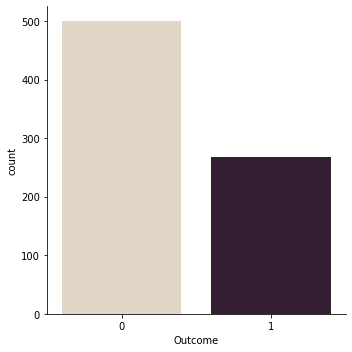

In [11]:
sns.catplot(x= 'Outcome', kind="count", palette="ch:.25", data=df);
# sns.countplot(data.Outcome)
print(df.Outcome.value_counts())

Задача бинарной классификации. Классы для небольшого размера датасета относительно сбалансированы, поэтому будем работать с этими данными.

Посмотрим на распределение данных в датасете

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


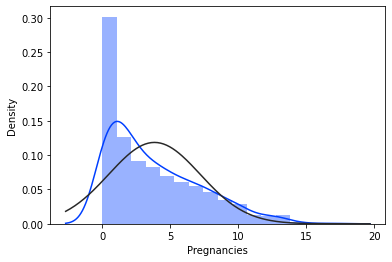

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


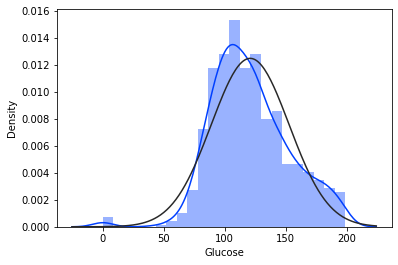

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


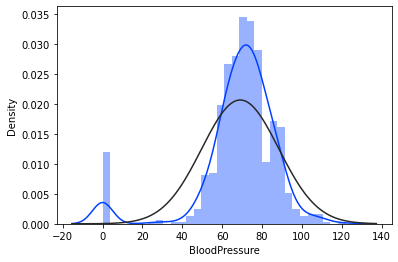

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


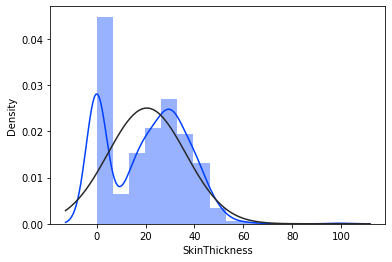

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


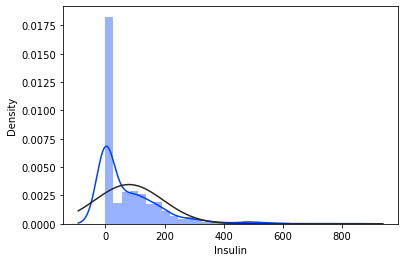

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


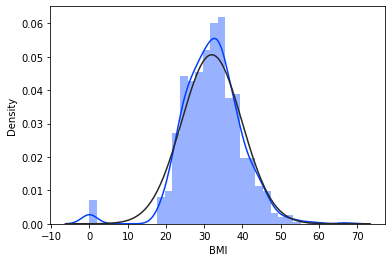

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


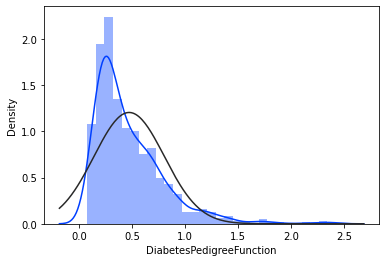

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


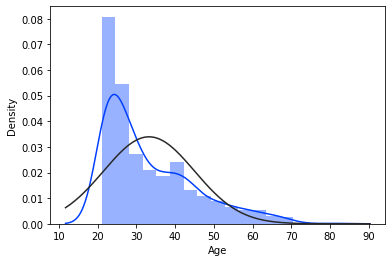

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


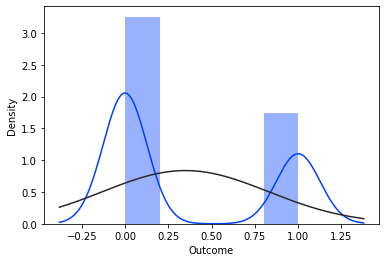

In [12]:
for i in df.columns:
    plt.figure()
    sns.distplot(df[i], fit = norm);
    plt.show()

У столбца ***Pregnances*** есть длинный хвост справа, также много пациентов, у которых значение инсулина в крови равно **0** (возможно неисправны приборы, измеряющие инсулин в крови). И отметим, что у некоторых признаков есть выбросы в распределении.

Посмотрим на распределение значений инсулина

In [13]:
df['Insulin'].value_counts()[:10]

0      374
105     11
130      9
140      9
120      8
94       7
180      7
100      7
135      6
115      6
Name: Insulin, dtype: int64

Преобладают нулевые значения. Давайте посмотрим как распределены нули среди людей, которые не болеют/болеют диабетом

In [14]:
zero_insulin = df[df.Insulin == 0]
zero_insulin.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0


In [15]:
zero_insulin[['Insulin','Outcome']]['Outcome'].value_counts()

0    236
1    138
Name: Outcome, dtype: int64

In [16]:
zero_insulin.groupby(['Outcome']).mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.961864,108.800847,67.305085,11.224576,0.0,28.837712,0.377665,34.432203
1,5.239130,137.550725,67.760870,11.992754,0.0,34.544203,0.479768,38.130435


Какой вывод можно здесь сделать?
Есть несколько предположений

*   Возможно низкие показатели инсулина в крови человека были округлены до ближайщего целого числа, учитывая что весь столбец состоит из целых чисел 
*   Некорректная/неиспрвная работа прибора, который изммерял инсулин в крови человека 



In [27]:
df_1 = df[['Age', 'Outcome']]
df_1['Outcome'] = df_1['Outcome'].map({0: 'not diabet', 1: 'diabet'})
df_1.head()

<ipython-input-27-6be5dcf97ad7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Outcome'] = df_1['Outcome'].map({0: 'not diabet', 1: 'diabet'})


,Age,Outcome
0,50,diabet
1,31,not diabet
2,32,diabet
3,21,not diabet
4,33,diabet


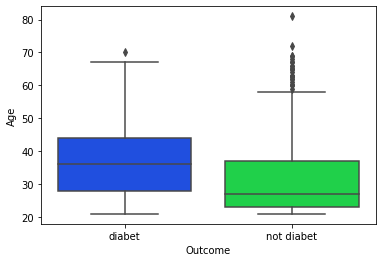

In [28]:
sns.boxplot(data=df_1, x="Outcome", y="Age");

Взрослые люди более склоны к диабету (вредные привычки, наследственность, стресс и т.п.)

Посмотрим корреляцию между данными

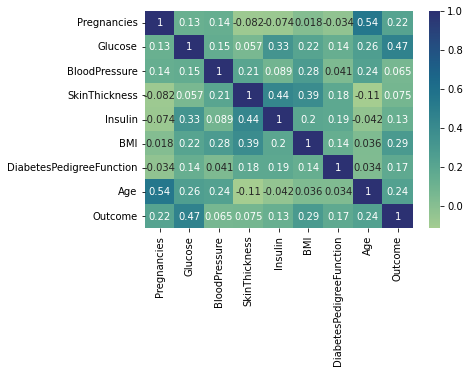

In [ ]:
sns.heatmap(df.corr(), cmap="crest", annot=True);

Сильных линейных зависимостей нет, поэтому оставим столбцы как есть

## Outlier Values

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


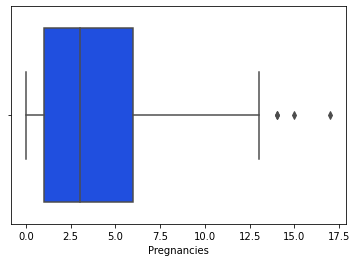

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


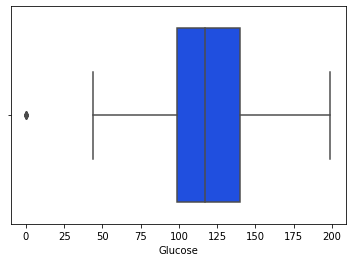

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


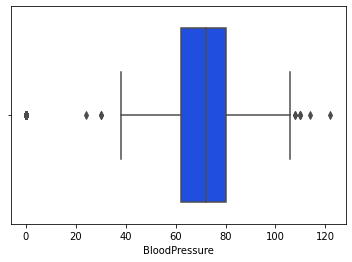

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


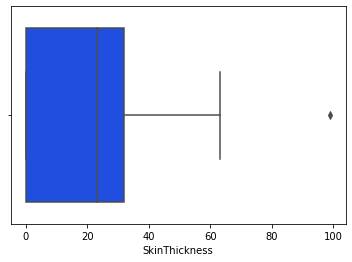

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


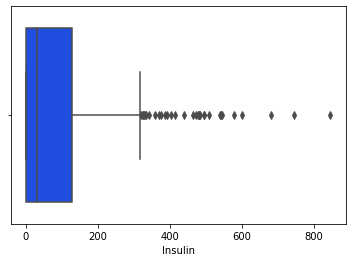

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


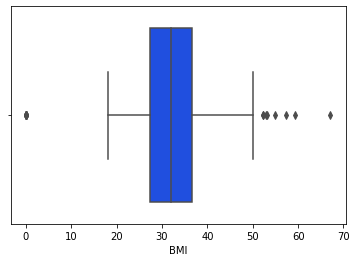

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


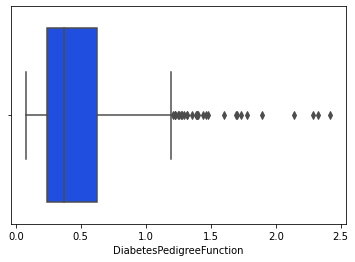

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


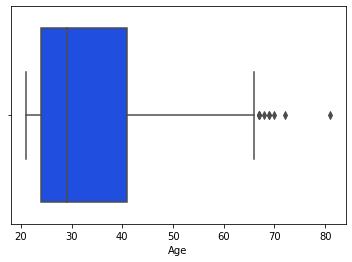

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


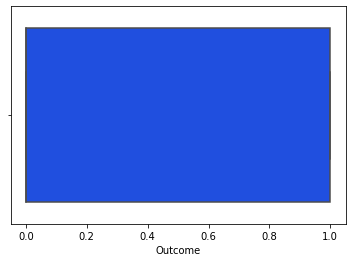

In [ ]:
for i in df.columns:
    plt.figure()
    sns.boxplot(x=df[i], orient='v');
    plt.show()

В ***Pregnancies*** как и предполагалось есть выбросы. Удалим их, используя значения межквартильного размаха.

In [ ]:
info_df = df.describe()
info_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
def cleanColumn(df, columns, thr = 2):
    column_info = info_df[columns]
    
    q3 = column_info[6]
    q1 = column_info[4]
    IQR = q3 - q1
    
    top_limit_clm = q3 + thr * IQR
    bottom_limit_clm = q1 - thr * IQR
    
    filter_clm_bottom = bottom_limit_clm < df[columns]
    filter_clm_top = df[columns] < top_limit_clm
    
    filters = filter_clm_bottom & filter_clm_top
    
    df = df[filters]
    
    print(f"{df.shape} of dataset after column {columns}")
    
    return df

In [ ]:
for i in df.columns:
  df = cleanColumn(df, i)

(767, 9) of dataset after column Pregnancies
(762, 9) of dataset after column Glucose
(725, 9) of dataset after column BloodPressure
(724, 9) of dataset after column SkinThickness
(702, 9) of dataset after column Insulin
(695, 9) of dataset after column BMI
(684, 9) of dataset after column DiabetesPedigreeFunction
(683, 9) of dataset after column Age
(683, 9) of dataset after column Outcome


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               683 non-null    int64  
 1   Glucose                   683 non-null    int64  
 2   BloodPressure             683 non-null    int64  
 3   SkinThickness             683 non-null    int64  
 4   Insulin                   683 non-null    int64  
 5   BMI                       683 non-null    float64
 6   DiabetesPedigreeFunction  683 non-null    float64
 7   Age                       683 non-null    int64  
 8   Outcome                   683 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 53.4 KB


## Feature Transformation

Оценим асимметрию данных количественно при помощи метода skew из библиотеки scipy

In [ ]:
skew_df = pd.DataFrame(df.columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(df[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_transform = skew_df[skew_df['Absolute Skew'] >= 1]
skew_transform

,Feature,Skew,Absolute Skew
4,Insulin,1.148896,1.148896
6,DiabetesPedigreeFunction,1.119475,1.119475
7,Age,1.055218,1.055218


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


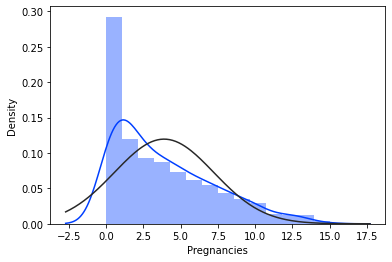

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


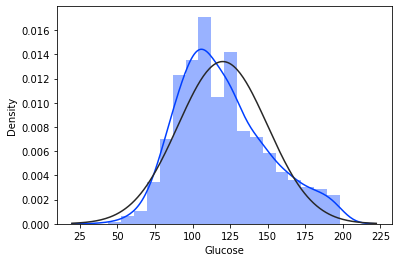

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


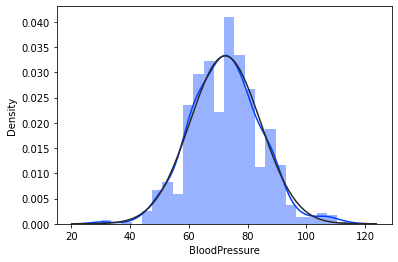

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


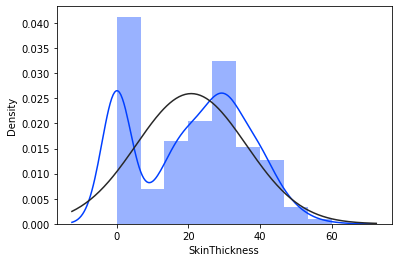

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


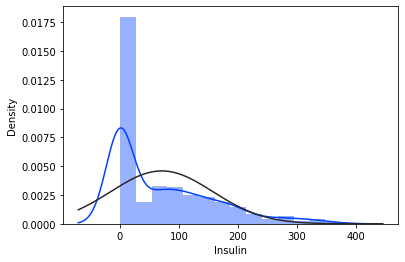

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


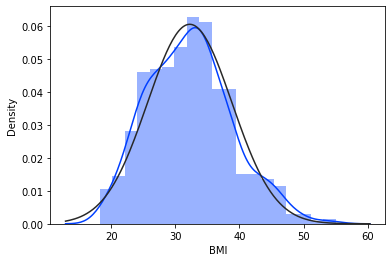

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


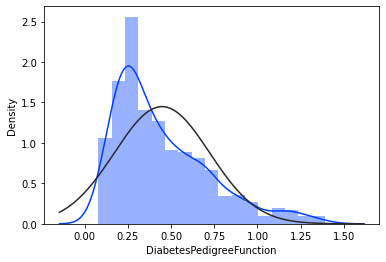

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


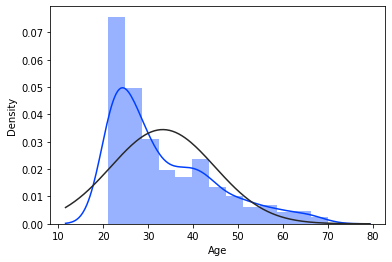

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


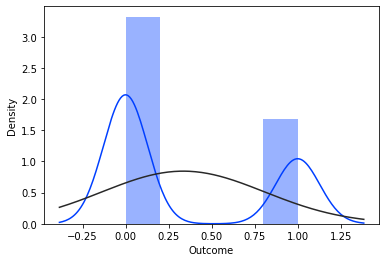

In [ ]:
for i in df.columns:
    plt.figure()
    sns.distplot(df[i], fit = norm);
    plt.show()

## Train Test Split

Разделим данные на тренировычные и тестовые выборки

In [ ]:
x = df.drop(["Outcome"], axis = 1)
y = df["Outcome"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

Нормализуем данные с помощью ***StandardScaler*** из библиотеки ***sklearn***

In [ ]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

In [ ]:
scaled_x_train

array([[ 1.58527906, -1.02779343, -0.33747454, ..., -1.22055099,
        -0.8902266 ,  2.17006514],
       [-1.14554932, -0.88956642,  0.67941784, ...,  0.64611129,
        -0.42015113, -0.60198751],
       [-1.14554932,  1.42573604,  0.34045371, ...,  3.18052268,
         1.1310979 , -0.68861415],
       ...,
       [-0.53869857, -0.02564759,  0.34045371, ...,  1.131747  ,
        -0.83598712, -0.34210757],
       [ 0.06815218, -0.7513394 , -0.33747454, ...,  0.08459499,
        -1.08910468,  0.00439901],
       [ 0.06815218, -0.82045291, -1.01540278, ..., -0.61350635,
        -0.01154708, -0.94849409]])

## Train Model 

Задача бинарной классификации, поэтому можно воспользоваться логистической регрессией. Но также будем менять порог (***threshold***), чтобы выбрать лучшую модель и на ней предсказывать тестовые данные. 

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
model = LogisticRegression()
model.fit(scaled_x_train, y_train)

LogisticRegression()

In [ ]:
accuracy_score(y_test, model.predict(scaled_x_test))

0.7894736842105263

In [ ]:
# model.predict_proba(scaled_x_test)

In [ ]:
pred_proba_df = pd.DataFrame(model.predict_proba(scaled_x_test)[:,1])
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(y_test, Y_test_pred)
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test, Y_test_pred))


******** For i = 0.05 ******
Our testing accuracy is 0.4619883040935672
[[20 92]
 [ 0 59]]

******** For i = 0.1 ******
Our testing accuracy is 0.5906432748538012
[[43 69]
 [ 1 58]]

******** For i = 0.15 ******
Our testing accuracy is 0.6608187134502924
[[57 55]
 [ 3 56]]

******** For i = 0.2 ******
Our testing accuracy is 0.7017543859649122
[[67 45]
 [ 6 53]]

******** For i = 0.25 ******
Our testing accuracy is 0.7134502923976608
[[74 38]
 [11 48]]

******** For i = 0.3 ******
Our testing accuracy is 0.7485380116959064
[[83 29]
 [14 45]]

******** For i = 0.35 ******
Our testing accuracy is 0.7543859649122807
[[87 25]
 [17 42]]

******** For i = 0.4 ******
Our testing accuracy is 0.7719298245614035
[[93 19]
 [20 39]]

******** For i = 0.45 ******
Our testing accuracy is 0.7953216374269005
[[99 13]
 [22 37]]

******** For i = 0.5 ******
Our testing accuracy is 0.7894736842105263
[[102  10]
 [ 26  33]]

******** For i = 0.55 ******
Our testing accuracy is 0.783625730994152
[[104   8

При пороге 0.45 точность модели составляет 0.79, что ненамного лучше чем при стандартном пороге в 0.5 (***Accuracy*** = 0.78). Поэтому можно изменить порог  

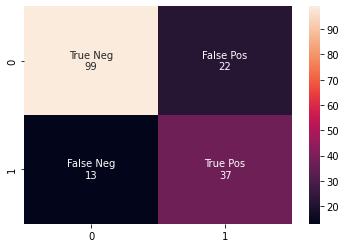

In [ ]:
Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>0.45 else 0)
conf_m = confusion_matrix(Y_test_pred, y_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                conf_m.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_m, annot=labels, fmt='');

Итоги:

*   Провел разведовательный анализ данных, где обнаружил неточности в данных (***Insulin*** = **0**), удалил выбросы и нормализовал все данные 
*   Обучил модель логистической регрессии, плавно меняя порог принятия решений и выбрал лучший порог

